In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Analysis**

In [2]:
cad_clean = pd.read_csv("data/cad_clean.csv")
cad_clean["Date"]= pd.to_datetime(cad_clean["Date"]).dt.floor("d")
cad_clean.head()

,Zipcode,Called,Responded,Date
0,97402,5E57,5E57,2016-01-01
1,97402,5E57,4X40,2016-01-01
2,97402,5E57,4E53,2016-01-01
3,97401,5T81,5T81,2016-01-01
4,97401,3X90,3F61,2016-01-01


In [3]:
#update dates
service = pd.to_datetime("2017-01-01")

In [4]:
before = cad_clean[(cad_clean["Date"] >= (service - pd.DateOffset(years=1))) & (cad_clean["Date"] <= service)]
after = cad_clean[(cad_clean["Date"] >= service) & (cad_clean["Date"] <= service + pd.DateOffset(years=1))]
before_size = before.shape[0]
after_size = after.shape[0]

In [5]:
#CH calls before additions
ch_before = before[(before["Called"] == "CAHOOTS") & (before["Responded"] == "CAHOOTS")]
calls_before = ch_before.shape[0]

In [6]:
#diverted to CH before additions
divert_before = before[(before["Called"] != "CAHOOTS") & (before["Responded"] == "CAHOOTS")]
divert_before_num = divert_before.shape[0]

In [7]:
#CH calls after additions
ch_after = after[(after["Called"] == "CAHOOTS") & (after["Responded"] == "CAHOOTS")]
calls_after = ch_after.shape[0]

In [8]:
#diverted to CH after additions
divert_after = after[(after["Called"] != "CAHOOTS") & (after["Responded"] == "CAHOOTS")]
divert_after_num = divert_after.shape[0]

**Calculations**

In [9]:
#calculate z-score

def z_score(c1, c2, n1, n2):
    p1 = c1 / n1
    p2 = c2 / n2
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2)) 
    p_value = 2 * (norm.cdf(-1 * abs(z)))
    return z, p_value

chcalls_z = z_score(calls_before, calls_after, before_size, after_size)
divert_z = z_score(divert_before_num, divert_after_num, before_size, after_size)

chcalls_z, divert_z

((-21.610533808691475, 1.4298602188539687e-103),
 (-3.1480437449632004, 0.0016436709364868328))

In [10]:
#CH calls by month
usable = cad_clean[cad_clean["Date"] < pd.to_datetime("2022-01-01") ]

ch_calls = usable[(usable["Responded"] == "CAHOOTS")]
other_calls = usable[(usable["Responded"] != "CAHOOTS")]

monthly_averages = usable.resample("M", on="Date").count()
ch_month = ch_calls.resample("M", on="Date").count()
other_month = other_calls.resample("M", on="Date").count()
monthly_averages["Total"] = monthly_averages["Responded"]
monthly_averages["CH %"] = (ch_month["Responded"] / monthly_averages["Total"]) * 100
monthly_averages.tail(5)

,Zipcode,Called,Responded,Total,CH %
Date,,,,,
2021-08-31,14855,14855,14855,14855,11.390104
2021-09-30,14510,14510,14510,14510,11.847002
2021-10-31,13970,13970,13970,13970,12.247674
2021-11-30,13817,13817,13817,13817,12.137222
2021-12-31,13507,13507,13507,13507,12.778559


In [11]:
months_x = monthly_averages.reset_index()[["Date"]]
months_x["Ordinal_Date"] = months_x["Date"].apply(lambda x: x.toordinal())
months_x.head()

,Date,Ordinal_Date
0,2016-01-31,735994
1,2016-02-29,736023
2,2016-03-31,736054
3,2016-04-30,736084
4,2016-05-31,736115


In [12]:
#linear regression

X = months_x[["Ordinal_Date"]]
y = monthly_averages["CH %"]

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [13]:
months = pd.date_range(start=usable['Date'].min(), end=usable['Date'].max(), freq='M')
years = pd.date_range(start=usable['Date'].min(), end=usable['Date'].max(), freq='YS')
month_labels = months.strftime('%B %Y')

In [14]:
#Linear Regression
X = months_x[["Ordinal_Date"]]
y = monthly_averages["CH %"]

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [15]:
#predictions
future_months = pd.date_range(start=usable["Date"].min(), end=pd.to_datetime("12-31-2035"), freq="M")

month_predictions = pd.DataFrame({"Date": future_months})
month_predictions["Ordinal_Date"] = month_predictions["Date"].apply(lambda x: x.toordinal())
prop_predictions = model.predict(month_predictions[["Ordinal_Date"]])
month_predictions["Percentage Predictions"] = prop_predictions

In [16]:
#diverted percentages
divert_before_prop = (divert_before_num / before_size) * 100
divert_after_prop = (divert_after_num / after_size) * 100
divert_props = pd.DataFrame({"Proportion" : [divert_before_prop, divert_after_prop]}, index=["Before Expansion",
                                                                                             "After Expansion"])

**Visualizations**

Text(0.5, 1.0, 'Percentage of Calls Diverted to CAHOOTS')

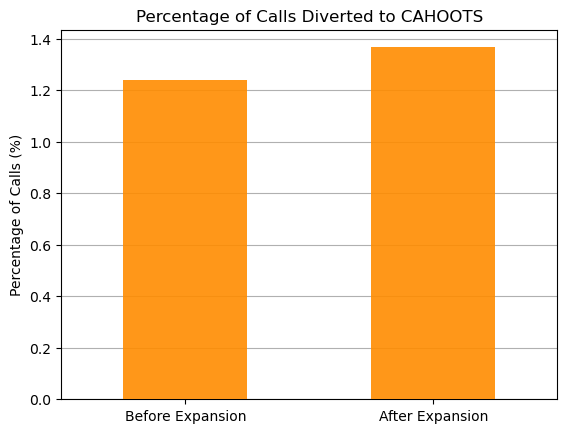

In [17]:
divert_props.plot(kind="bar", legend=None, zorder=3, alpha=0.9, color="darkorange")
plt.grid(axis="y", zorder=0 )
plt.xticks(rotation=0)
plt.ylabel("Percentage of Calls (%)")
plt.title("Percentage of Calls Diverted to CAHOOTS")

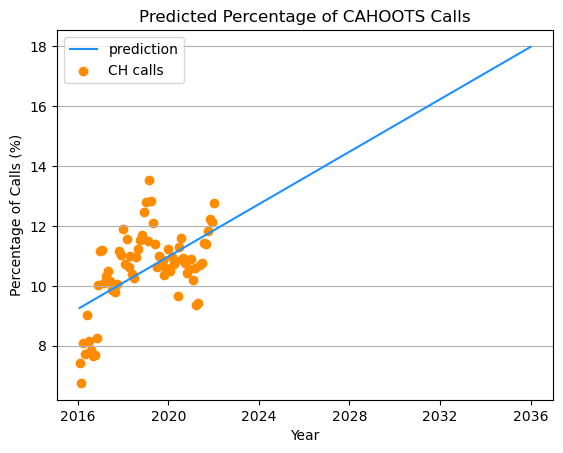

In [18]:
plt.plot(future_months, month_predictions["Percentage Predictions"], color = "dodgerblue", label = "prediction")  
plt.scatter(months, monthly_averages["CH %"], color = "darkorange", label = "CH calls")
plt.xlabel("Year")
plt.ylabel("Percentage of Calls (%)")
plt.title("Predicted Percentage of CAHOOTS Calls")
plt.legend()
plt.grid(axis="y", zorder=0)

Text(2016-02-29 00:00:00, 10.6, 'Update')

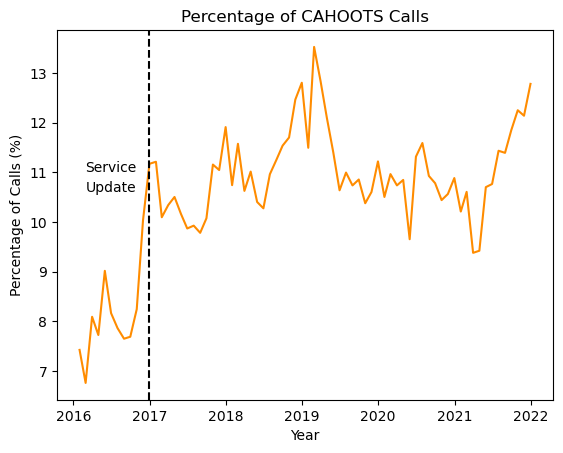

In [19]:
plt.plot(months, monthly_averages["CH %"], color = "darkorange")
plt.xlabel("Year")
plt.ylabel("Percentage of Calls (%)")
plt.title("Percentage of CAHOOTS Calls")
plt.axvline(x = months[11], color = 'black', linestyle = "dashed")
plt.text(months[1], 11, "Service")
plt.text(months[1], 10.6, "Update")